In [1]:
# Importing SparkSession and Creating an Object
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('unsupervised_learning').getOrCreate()

In [3]:
# Several libraries
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.clustering import KMeans

In [4]:
df = spark.read.csv('music_data.csv',inferSchema=True,header=True)
df.count()

429023

In [5]:
df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- music category: string (nullable = true)



In [6]:
df.select('music category').distinct().count()

21

In [8]:
df.groupBy('music category').count().orderBy('count',ascending=False).show(100,False)

+-----------------+-----+
|music category   |count|
+-----------------+-----+
|Alternative Music|64227|
|Blues            |54647|
|Classical Music  |43117|
|Country Music    |39891|
|Dance Music      |35779|
|Easy Listening   |34356|
|Electronic Music |30985|
|Rap              |29569|
|Hip Hop          |16895|
|Indie Pop        |16244|
|Motivational     |10118|
|Asian Pop        |8444 |
|Jazz             |7685 |
|Latin Music      |7302 |
|New Age          |7053 |
|Opera            |6188 |
|Hindi Music      |5689 |
|Popular          |4729 |
|Soulful          |2403 |
|Reggae           |1970 |
|Rock             |1732 |
+-----------------+-----+



In [9]:
df.select('user_id').distinct().count()

775

In [11]:
df.groupBy('user_id').count().orderBy('count',ascending=False).show(20,False)

+----------------------------------------------------------------+-----+
|user_id                                                         |count|
+----------------------------------------------------------------+-----+
|628119a73b9725466e6c309f803d30cfc3b11d2a426cdd5f0d62a496e105c914|14257|
|179dd34be075e729f14dadc28a34459226c4f62797af5f186bddbb7428b8fc78|11804|
|2d765ea4ffc6554c95a1c703afcd3470bc118a65c2f0728871f4d0f40628f41b|11001|
|ca60aad85306a7fdd51a469ca6a5d27109dfd5f5781d7da985c70574d2520d23|10479|
|03bfd7e24d3a7ce9e3973f9d42ad89e4c1710b89bec59b2b08712ba73372dcbc|10075|
|7660ca8a4f5df748976aac001d5f0c5b7c8806f5c08197542d26c2eac4b20f85|9932 |
|b6eb8ef9cacc79b6779a7e065c3b0fb5174397ea983d70453bc978b6e46f95e2|7694 |
|e92f348b4a29089c9d7b82095d0bd49422153b60bbde08527015121e44699990|7210 |
|da03e0ef521fecb209f01410eefff11c115fda2d217dde51fd870761b31bb968|7182 |
|04cd1fc5c925a8a702607d6c1a047b8e0cbe170bdaed5270369d321f73254b53|6853 |
|a2374ccb47b0af60aafabeed11b979acf0d72e1afe7f96b671

In [12]:
df.groupBy('user_id').count().orderBy('count',acsending=True).show(20,False)

+----------------------------------------------------------------+-----+
|user_id                                                         |count|
+----------------------------------------------------------------+-----+
|a09074b27cd4ab61654c0f4e21bc5e97dc86a611743a1f8b37db3a76df8e306e|1    |
|54f2e60bd31a775aca7fb60816c6990a415fe66694098d1ee64cc9e13f831a64|1    |
|e6e6ceb674b7ca53391ac404558a3f8d222db82c643b8c21070db4f029a50095|1    |
|1e3e7153bf1aa5f43b1d1f27c940087587a50d40d399f4cf31b58546a39b9f26|1    |
|4d5920f000b000d60fdc63043886f47cc056d2835d3a73e50f389a5694b19115|1    |
|402c7aac3776a3758ca143819a0653c6cd33c6c35dd831d9ba5aad1dff43a888|1    |
|8691b41f5ae65644c8aca0ec9d738eb3b5537b106f0fdcb3f652cc77b7ab7dd6|1    |
|ba35ab150a757e0b3abf9c5f11b7686e5394f6cdcb59d257f9fd2e1dd7cf23c2|1    |
|597affc56ba81274561da2b3541a8e1a30f7bbcf75cb54a9f9c1a885d88f7f7b|1    |
|8aced64c96741dbeab4659f102f34c157189b3f7a63807d87bad5d8c663005cb|1    |
|1e6fb89e6aca7641dba8bbd87e97badb8306f1ce50c02c2b0a

In [13]:
# Reshaping a Dataframe for Clustering
feature_df = df.stat.crosstab('user_id','music category')
feature_df.printSchema()

root
 |-- user_id_music category: string (nullable = true)
 |-- Alternative Music: long (nullable = true)
 |-- Asian Pop: long (nullable = true)
 |-- Blues: long (nullable = true)
 |-- Classical Music: long (nullable = true)
 |-- Country Music: long (nullable = true)
 |-- Dance Music: long (nullable = true)
 |-- Easy Listening: long (nullable = true)
 |-- Electronic Music: long (nullable = true)
 |-- Hindi Music: long (nullable = true)
 |-- Hip Hop: long (nullable = true)
 |-- Indie Pop: long (nullable = true)
 |-- Jazz: long (nullable = true)
 |-- Latin Music: long (nullable = true)
 |-- Motivational: long (nullable = true)
 |-- New Age: long (nullable = true)
 |-- Opera: long (nullable = true)
 |-- Popular: long (nullable = true)
 |-- Rap: long (nullable = true)
 |-- Reggae: long (nullable = true)
 |-- Rock: long (nullable = true)
 |-- Soulful: long (nullable = true)



In [14]:
feature_df.show(3,False)

+----------------------------------------------------------------+-----------------+---------+-----+---------------+-------------+-----------+--------------+----------------+-----------+-------+---------+----+-----------+------------+-------+-----+-------+---+------+----+-------+
|user_id_music category                                          |Alternative Music|Asian Pop|Blues|Classical Music|Country Music|Dance Music|Easy Listening|Electronic Music|Hindi Music|Hip Hop|Indie Pop|Jazz|Latin Music|Motivational|New Age|Opera|Popular|Rap|Reggae|Rock|Soulful|
+----------------------------------------------------------------+-----------------+---------+-----+---------------+-------------+-----------+--------------+----------------+-----------+-------+---------+----+-----------+------------+-------+-----+-------+---+------+----+-------+
|ca3c4285512798abe7d81fa2d0588549211be9516d9b2050e5564f8e912312c7|65               |0        |7    |8              |7            |12         |7             |

In [15]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [16]:
print(feature_df.columns)

['user_id_music category', 'Alternative Music', 'Asian Pop', 'Blues', 'Classical Music', 'Country Music', 'Dance Music', 'Easy Listening', 'Electronic Music', 'Hindi Music', 'Hip Hop', 'Indie Pop', 'Jazz', 'Latin Music', 'Motivational', 'New Age', 'Opera', 'Popular', 'Rap', 'Reggae', 'Rock', 'Soulful']


In [18]:
feat_cols = [col for col in feature_df.columns if col != 'user_id_music category']
print(feat_cols)

['Alternative Music', 'Asian Pop', 'Blues', 'Classical Music', 'Country Music', 'Dance Music', 'Easy Listening', 'Electronic Music', 'Hindi Music', 'Hip Hop', 'Indie Pop', 'Jazz', 'Latin Music', 'Motivational', 'New Age', 'Opera', 'Popular', 'Rap', 'Reggae', 'Rock', 'Soulful']


In [19]:
vec_assembler = VectorAssembler(inputCols=feat_cols,outputCol='features')
final_data = vec_assembler.transform(feature_df)
final_data.printSchema()

root
 |-- user_id_music category: string (nullable = true)
 |-- Alternative Music: long (nullable = true)
 |-- Asian Pop: long (nullable = true)
 |-- Blues: long (nullable = true)
 |-- Classical Music: long (nullable = true)
 |-- Country Music: long (nullable = true)
 |-- Dance Music: long (nullable = true)
 |-- Easy Listening: long (nullable = true)
 |-- Electronic Music: long (nullable = true)
 |-- Hindi Music: long (nullable = true)
 |-- Hip Hop: long (nullable = true)
 |-- Indie Pop: long (nullable = true)
 |-- Jazz: long (nullable = true)
 |-- Latin Music: long (nullable = true)
 |-- Motivational: long (nullable = true)
 |-- New Age: long (nullable = true)
 |-- Opera: long (nullable = true)
 |-- Popular: long (nullable = true)
 |-- Rap: long (nullable = true)
 |-- Reggae: long (nullable = true)
 |-- Rock: long (nullable = true)
 |-- Soulful: long (nullable = true)
 |-- features: vector (nullable = true)



In [20]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features",outputCol="scaledFeatures",withStd=True,withMean=False)
scalerModel = scaler.fit(final_data)
cluster_final_data = scalerModel.transform(final_data)
cluster_final_data.columns

['user_id_music category',
 'Alternative Music',
 'Asian Pop',
 'Blues',
 'Classical Music',
 'Country Music',
 'Dance Music',
 'Easy Listening',
 'Electronic Music',
 'Hindi Music',
 'Hip Hop',
 'Indie Pop',
 'Jazz',
 'Latin Music',
 'Motivational',
 'New Age',
 'Opera',
 'Popular',
 'Rap',
 'Reggae',
 'Rock',
 'Soulful',
 'features',
 'scaledFeatures']

In [22]:
from pyspark.ml.evaluation import ClusteringEvaluator
errors = []
for k in range(2,10):
    kmeans = KMeans(featuresCol='scaledFeatures',k=k)
    model = kmeans.fit(cluster_final_data)
    predictions = model.transform(cluster_final_data)
    evaluator = ClusteringEvaluator()
    # wssse = model.computeCost(cluster_final_data) ComputeCost deprecated in this version
    silhouette = evaluator.evaluate(predictions)
    errors.append(silhouette)
    print('With K={}'.format(k))
    print('Silhouette with Squared Euclidean Distance = ' + str(silhouette))
    print('--'* 30)

With K=2
Silhouette with Squared Euclidean Distance = 0.9304216402327824
------------------------------------------------------------
With K=3
Silhouette with Squared Euclidean Distance = 0.9574194776012076
------------------------------------------------------------
With K=4
Silhouette with Squared Euclidean Distance = 0.8667447250029943
------------------------------------------------------------
With K=5
Silhouette with Squared Euclidean Distance = 0.761303997702623
------------------------------------------------------------
With K=6
Silhouette with Squared Euclidean Distance = 0.7307178657389923
------------------------------------------------------------
With K=7
Silhouette with Squared Euclidean Distance = 0.8024799205519666
------------------------------------------------------------
With K=8
Silhouette with Squared Euclidean Distance = 0.8055931181709692
------------------------------------------------------------
With K=9
Silhouette with Squared Euclidean Distance = 0.7716704

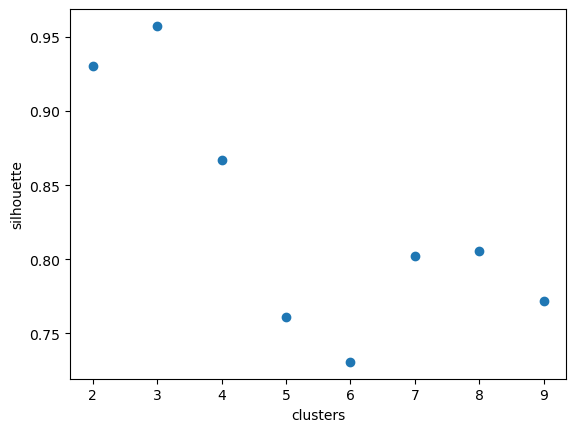

In [23]:
cluster_number = range(2,10)
plt.scatter(cluster_number,errors)
plt.xlabel('clusters')
plt.ylabel('silhouette')
plt.show()

In [24]:
kmeans6 = KMeans(featuresCol='scaledFeatures',k=6)
model_k6 = kmeans6.fit(cluster_final_data)
model_k6.transform(cluster_final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|    1|
|         3|    7|
|         4|  672|
|         2|    8|
|         0|   86|
|         5|    1|
+----------+-----+



In [25]:
model_k6.transform(cluster_final_data).show()

+----------------------+-----------------+---------+-----+---------------+-------------+-----------+--------------+----------------+-----------+-------+---------+----+-----------+------------+-------+-----+-------+---+------+----+-------+--------------------+--------------------+----------+
|user_id_music category|Alternative Music|Asian Pop|Blues|Classical Music|Country Music|Dance Music|Easy Listening|Electronic Music|Hindi Music|Hip Hop|Indie Pop|Jazz|Latin Music|Motivational|New Age|Opera|Popular|Rap|Reggae|Rock|Soulful|            features|      scaledFeatures|prediction|
+----------------------+-----------------+---------+-----+---------------+-------------+-----------+--------------+----------------+-----------+-------+---------+----+-----------+------------+-------+-----+-------+---+------+----+-------+--------------------+--------------------+----------+
|  ca3c4285512798abe...|               65|        0|    7|              8|            7|         12|             7|         

In [26]:
cluster_prediction = model_k6.transform(cluster_final_data)
cluster_prediction.printSchema()

root
 |-- user_id_music category: string (nullable = true)
 |-- Alternative Music: long (nullable = true)
 |-- Asian Pop: long (nullable = true)
 |-- Blues: long (nullable = true)
 |-- Classical Music: long (nullable = true)
 |-- Country Music: long (nullable = true)
 |-- Dance Music: long (nullable = true)
 |-- Easy Listening: long (nullable = true)
 |-- Electronic Music: long (nullable = true)
 |-- Hindi Music: long (nullable = true)
 |-- Hip Hop: long (nullable = true)
 |-- Indie Pop: long (nullable = true)
 |-- Jazz: long (nullable = true)
 |-- Latin Music: long (nullable = true)
 |-- Motivational: long (nullable = true)
 |-- New Age: long (nullable = true)
 |-- Opera: long (nullable = true)
 |-- Popular: long (nullable = true)
 |-- Rap: long (nullable = true)
 |-- Reggae: long (nullable = true)
 |-- Rock: long (nullable = true)
 |-- Soulful: long (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)
 |-- prediction: integer (nullab

In [27]:
from pyspark.ml.feature import PCA
pca = PCA(k=3,inputCol='scaledFeatures',outputCol='pca_features')
pca_model = pca.fit(cluster_prediction)
result = pca_model.transform(cluster_prediction).select('user_id_music category','pca_features','prediction')
result.show(truncate=False)

+----------------------------------------------------------------+---------------------------------------------------------------+----------+
|user_id_music category                                          |pca_features                                                   |prediction|
+----------------------------------------------------------------+---------------------------------------------------------------+----------+
|ca3c4285512798abe7d81fa2d0588549211be9516d9b2050e5564f8e912312c7|[-0.22507350265162823,0.15082893636632247,-0.13922132997808484]|4         |
|b457919ae168ac12ec7e0303ae0d5fe292b63c9d04eb54e039942e7f46552ec4|[-0.5273003162834192,0.10206886950980026,-0.014971360310926114]|4         |
|a87bb168ba6e5a8da5eccce18c95565d843b40c1833b0f6c3089eb083f0fe3d3|[-0.23968261020295822,0.2801153618243119,-0.17382194436381881] |4         |
|cf60c9b1a0444261c3a4687677f5336686b96756df5e33c11f6016f16fb38372|[-3.512051591993016,0.3272943318957352,1.1017302617933127]     |0         |
|8ab21

In [28]:
clusters = result.toPandas().set_index('user_id_music category')
clusters.head(10)

,pca_features,prediction
user_id_music category,,
ca3c4285512798abe7d81fa2d0588549211be9516d9b2050e5564f8e912312c7,"[-0.22507350265162823, 0.15082893636632247, -0...",4
b457919ae168ac12ec7e0303ae0d5fe292b63c9d04eb54e039942e7f46552ec4,"[-0.5273003162834192, 0.10206886950980026, -0....",4
a87bb168ba6e5a8da5eccce18c95565d843b40c1833b0f6c3089eb083f0fe3d3,"[-0.23968261020295822, 0.2801153618243119, -0....",4
cf60c9b1a0444261c3a4687677f5336686b96756df5e33c11f6016f16fb38372,"[-3.512051591993016, 0.3272943318957352, 1.101...",0
8ab21c1b361d5c4aa1ed01893305febf1c6659bd342217eece1225d789ba57da,"[-0.6796385576703682, 0.3960805354648381, 0.11...",4
34e22754ffec4a0d434edfa0f3b10c0e1ab14c632cee37514076d211cf1e7017,"[-2.0964050329364157, 0.9121320035474159, 0.99...",0
ad3ea6999df3120ccb557d34cf75e17dfdd3febe445e9e1bc36514642fcd3bdb,"[-0.2944449488892162, 0.3839780472651297, 0.07...",4
3d2ea50eeeb98d4a79259ee057955696ec9dc46e1b72e8d8eff099feb3362e1f,"[-0.9356027216181406, 0.5958240577216141, -0.1...",4
334533d21eeed37dd2b686022857f9f42eef9fa6192a8653040af844be8d15ef,"[-0.138861582778022, 0.1578422249327619, -0.11...",4


In [29]:
clusters[['x','y','z']] = pd.DataFrame(clusters.pca_features.values.tolist(),index=clusters.index)
clusters.head(10)

,pca_features,prediction,x,y,z
user_id_music category,,,,,
ca3c4285512798abe7d81fa2d0588549211be9516d9b2050e5564f8e912312c7,"[-0.22507350265162823, 0.15082893636632247, -0...",4,-0.225074,0.150829,-0.139221
b457919ae168ac12ec7e0303ae0d5fe292b63c9d04eb54e039942e7f46552ec4,"[-0.5273003162834192, 0.10206886950980026, -0....",4,-0.527300,0.102069,-0.014971
a87bb168ba6e5a8da5eccce18c95565d843b40c1833b0f6c3089eb083f0fe3d3,"[-0.23968261020295822, 0.2801153618243119, -0....",4,-0.239683,0.280115,-0.173822
cf60c9b1a0444261c3a4687677f5336686b96756df5e33c11f6016f16fb38372,"[-3.512051591993016, 0.3272943318957352, 1.101...",0,-3.512052,0.327294,1.101730
8ab21c1b361d5c4aa1ed01893305febf1c6659bd342217eece1225d789ba57da,"[-0.6796385576703682, 0.3960805354648381, 0.11...",4,-0.679639,0.396081,0.114741
34e22754ffec4a0d434edfa0f3b10c0e1ab14c632cee37514076d211cf1e7017,"[-2.0964050329364157, 0.9121320035474159, 0.99...",0,-2.096405,0.912132,0.991261
ad3ea6999df3120ccb557d34cf75e17dfdd3febe445e9e1bc36514642fcd3bdb,"[-0.2944449488892162, 0.3839780472651297, 0.07...",4,-0.294445,0.383978,0.077588
3d2ea50eeeb98d4a79259ee057955696ec9dc46e1b72e8d8eff099feb3362e1f,"[-0.9356027216181406, 0.5958240577216141, -0.1...",4,-0.935603,0.595824,-0.175242
334533d21eeed37dd2b686022857f9f42eef9fa6192a8653040af844be8d15ef,"[-0.138861582778022, 0.1578422249327619, -0.11...",4,-0.138862,0.157842,-0.112606


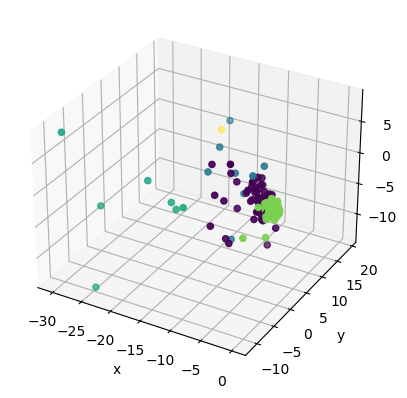

In [34]:
from mpl_toolkits.mplot3d import Axes3D
cluster_vis = plt.figure().add_subplot(projection='3d')
cluster_vis.scatter(clusters.x,clusters.y,clusters.z,c=clusters.prediction)
cluster_vis.set_xlabel('x')
cluster_vis.set_ylabel('y')
cluster_vis.set_zlabel('z')
plt.show()